In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchtext.functional as F

import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# specify device
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Hyperparameters

In [2]:
USE_GPU = torch.cuda.is_available()
DROPOUT = .1
best_dev_acc = 0.0

EMBEDDING_TYPE = 'glove'
EPOCHS = 8
EMBEDDING_DIM = 300
HIDDEN_DIM = 50
BATCH_SIZE = 128
USE_BILSTM = True
LEARNING_RATE = 1e-4
do_freeze_embedding = False

## Load Dataset

In [3]:
data = pd.read_csv('data.csv')

# See how the data looks like
print(data.shape)
data.head()

(64296, 2)


,label,text
0,1,Says the Annies List political group supports ...
1,0,When did the decline of coal start? It started...
2,0,"Hillary Clinton agrees with John McCain ""by vo..."
3,1,Health care reform legislation is likely to ma...
4,0,The economic turnaround started at the end of ...


## Define Text Transform

In [4]:
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader

padding_idx = 1
bos_idx = 0
eos_idx = 2
max_seq_len = 65
xlmr_vocab_path = r"https://download.pytorch.org/models/text/xlmr.vocab.pt"
xlmr_spm_model_path = r"https://download.pytorch.org/models/text/xlmr.sentencepiece.bpe.model"

text_transform = T.Sequential(
    T.SentencePieceTokenizer(xlmr_spm_model_path),
    T.VocabTransform(load_state_dict_from_url(xlmr_vocab_path)),
    T.Truncate(max_seq_len),# - 2
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
)

## Split Train and Test Set

In [5]:
# train: test: val = 70:15:15
train_text, val_test_text, train_labels, val_test_labels = train_test_split(
    data['text'],
    data['label'],
    test_size=0.3,
    random_state=733,
    stratify=data['label']
)
val_text, test_text, val_labels, test_labels = train_test_split(
    val_test_text,
    val_test_labels,
    test_size=0.5,
    random_state=733,
    stratify=val_test_labels
)

## Prepare Input Data

In [6]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = BATCH_SIZE

transformed_train = train_text.map(lambda x: text_transform(x))
transformed_val = val_text.map(lambda x: text_transform(x))
transformed_test = test_text.map(lambda x: text_transform(x))

train_X = F.to_tensor(text_transform(train_text.to_list()), padding_value=padding_idx)
val_X = F.to_tensor(text_transform(val_text.to_list()), padding_value=padding_idx)
test_X = F.to_tensor(text_transform(test_text.to_list()), padding_value=padding_idx)

train_y = torch.tensor(train_labels.tolist())
val_y = torch.tensor(val_labels.tolist())
test_y = torch.tensor(test_labels.tolist())

### Data Loader

In [7]:
train_data = TensorDataset(train_X, train_y)
train_sampler = RandomSampler(train_data)                     
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size=BATCH_SIZE)
                                                              
val_data = TensorDataset(val_X, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_X, test_y)     
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=BATCH_SIZE)

## Define Word Embedding

In [8]:
def maybe_gpu(v):
    return v.cuda() if USE_GPU else v

In [9]:
# obtain the vocabulary of the data pipeline, so that we can convert word <--> word_index
# allowing us to plug in different word embeddings
vocab = text_transform[1].vocab.vocab
word_to_idx = vocab.get_stoi()

In [10]:
from torchtext.vocab import GloVe
glove_vectors = GloVe(name="6B")
EMBEDDING_DIM = glove_vectors.vectors.shape[1]
# prepare random embedding, then fill in glove vectors
pretrained_embeddings = np.random.uniform(-0.25, 0.25, (len(vocab), EMBEDDING_DIM)).astype('f')
pretrained_embeddings[0] = 0
for word, wi in glove_vectors.stoi.items():
    try:
        pretrained_embeddings[word_to_idx[word]-1] = glove_vectors.__getitem__(word)
    except KeyError:
        pass
pretrained_embeddings = maybe_gpu(torch.from_numpy(pretrained_embeddings))

## Prepare LSTM Model

### Model Architecture

In [11]:
from torch.autograd import Variable
import torch.nn.functional as nnF

class LSTMArch(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size,
                 use_gpu, batch_size, dropout=0.5, bidirectional=False, classifier_head=None):
        """Prepare individual layers"""
        super(LSTMArch, self).__init__()
        self.hidden_dim = hidden_dim
        self.use_gpu = use_gpu
        self.batch_size = batch_size
        self.dropout = dropout
        self.num_directions = 2 if bidirectional else 1
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, bidirectional=bidirectional)
        self.hidden2label = nn.Linear(hidden_dim*self.num_directions, label_size)
        self.hidden = self.init_hidden()
        self.classifier_head = classifier_head

    def init_hidden(self, batch_size=None):
        """Choose appropriate size and type of hidden layer"""
        if not batch_size:
            batch_size = self.batch_size
        #what = torch.randn
        what = torch.zeros
        # first is the hidden h
        # second is the cell c
        return (maybe_gpu(Variable(what(self.num_directions, batch_size, self.hidden_dim))),
                maybe_gpu(Variable(what(self.num_directions, batch_size, self.hidden_dim))))

    def classify(self, features):
        y = self.hidden2label(features)
        log_probs = nnF.log_softmax(y, dim=1)
        return log_probs

    def forward(self, sentence):
        """Use the layers of this model to propagate input and return class log probabilities"""
        if self.use_gpu:
            sentence = sentence.cuda()
        x = self.embeddings(sentence).permute(1,0,2)
        batch_size = x.shape[1]
        self.hidden = self.init_hidden(batch_size=batch_size)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        features = lstm_out[-1]
        log_probs = self.classify(features)
        return log_probs

In [12]:
lstm_model = LSTMArch(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                            vocab_size=len(vocab), label_size=2,\
                            use_gpu=USE_GPU, batch_size=BATCH_SIZE, dropout=DROPOUT, bidirectional=USE_BILSTM)
lstm_model.embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=do_freeze_embedding)
model = lstm_model

### Training Methods

In [13]:
import lightning.pytorch as pl

from torch.optim import Adam

class LitModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.train()
        self.criteria = nn.NLLLoss()

    def training_step(self, batch, batch_idx):
        sent_id, labels = batch
        output = self.model(sent_id)
        loss = self.criteria(output, labels)
        
        # compute step accuracy
        correct_predictions = (output.argmax(1) == labels).sum().item()
        total_predictions = len(labels)
        acc = correct_predictions / total_predictions
        
        # pass performance info to logger
        self.log("train_loss", loss, on_step = False, on_epoch=True, batch_size=BATCH_SIZE, logger=True)
        self.log('train_accuracy', acc, on_step = False, on_epoch=True, batch_size=BATCH_SIZE, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        sent_id, labels = batch
        output = self.model(sent_id)
        loss = self.criteria(output, labels)
        
        # compute step accuracy
        correct_predictions = (output.argmax(1) == labels).sum().item()
        total_predictions = len(labels)
        acc = correct_predictions / total_predictions
        
        # pass performance info to logger
        self.log("val_loss", loss, on_step = False, on_epoch=True, batch_size=BATCH_SIZE, logger=True)
        self.log('val_accuracy', acc, on_step = False, on_epoch=True, batch_size=BATCH_SIZE, logger=True)

        return loss

    def configure_optimizers(self):
        return Adam(self.model.parameters(), lr=LEARNING_RATE)

/usr/shared/CMPT/big-data/condaenv/gt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

tb_logdir = "logs-proj"

logger = TensorBoardLogger(tb_logdir, name="LSTM_model")
trainer = Trainer(logger=logger, max_epochs=EPOCHS)
torch.cuda.empty_cache()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(LitModel(model), train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | model    | LSTMArch | 75.1 M
1 | criteria | NLLLoss  | 0     
--------------------------------------
75.1 M    Trainable params
0         Non-trainable params
75.1 M    Total params
300.566   Total estimated model params size (MB)
2023-04-10 11:52:28.728261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 11:52:28.808905: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF

/usr/shared/CMPT/big-data/condaenv/gt/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/shared/CMPT/big-data/condaenv/gt/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|███████████████████████| 352/352 [00:07<00:00, 47.94it/s, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████████████| 352/352 [00:07<00:00, 48.25it/s, v_num=0]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  18%|███▏             | 14/76 [00:00<00:00, 275.57it/s]


Epoch 2: 100%|███████████████████████| 352/352 [00:07<00:00, 48.00it/s, v_num=0]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  42%|███████▏         | 32/76 [00:00<00:00, 307.76it/s]


Epoch 3: 100%|███████████████████████| 352/352 [00:07<00:00, 48.01it/s, v_num=0]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  66%|███████████▏     | 50/76 [00:00<00:00, 324.06it/s]


Epoch 4: 100%|███████████████████████| 352/352 [00:07<00:00, 47.95it/s, v_num=0]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  89%|███████████████▏ | 68/76 [00:00<00:00, 320.22it/s]


Epoch 5: 100%|███████████████████████| 352/352 [00:07<00:00, 48.07it/s, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|███████████████████████| 352/352 [00:07<00:00, 48.00it/s, v_num=0]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   8%|█▍                | 6/76 [00:00<00:00, 200.92it/s]


Epoch 7: 100%|███████████████████████| 352/352 [00:07<00:00, 47.96it/s, v_num=0]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  32%|█████▎           | 24/76 [00:00<00:00, 288.70it/s]


Epoch 7: 100%|███████████████████████| 352/352 [00:07<00:00, 46.46it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|███████████████████████| 352/352 [00:16<00:00, 21.29it/s, v_num=0]


In [16]:
torch.save(model.state_dict(), "LSTM_based.pt")

In [17]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load("LSTM_based.pt"))
model.to(DEVICE)

model.eval()
pred_y = []
groud_y = []
with torch.no_grad():
    for test in test_dataloader:
        test_seq, test_labels = test
        test_seq.to(DEVICE)
        test_labels.to(DEVICE)
        
        output = model(test_seq)
        output = np.argmax(output.detach().cpu().numpy(), axis=1)
        pred_y.extend(output.tolist())
        groud_y.extend(test_labels.detach().cpu().numpy().tolist())

print(classification_report(groud_y, pred_y))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92      5373
           1       0.98      0.81      0.89      4272

    accuracy                           0.91      9645
   macro avg       0.92      0.90      0.90      9645
weighted avg       0.92      0.91      0.91      9645



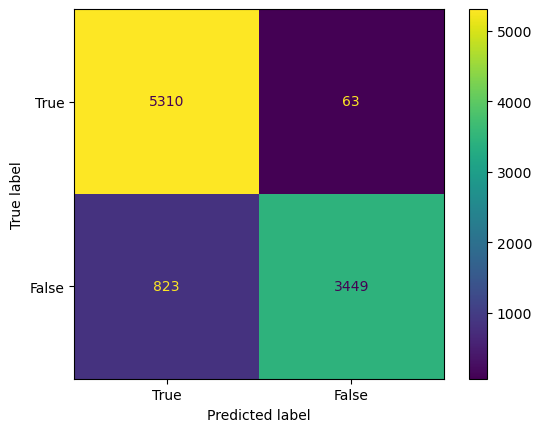

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(groud_y, pred_y)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [True, False])

cm_display.plot()
plt.show() 